In [186]:
import os
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import ComplementNB
from sklearn.linear_model import RidgeClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE

from opendp.whitenoise.synthesizers.mwem import MWEMSynthesizer

import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [174]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
adult = pd.read_csv('adult_4000.csv')

adult_cat_ord = adult.copy()

categorical_columns = ['workclass',
                       'marital-status', 
                       'occupation', 
                       'relationship', 
                       'race',
                       'gender',
                       'native-country',
                       'income']

ordinal_columns = ['education']

encoders = {}
for column in adult.columns:
    if adult.dtypes[column] == np.object:
        encoders[column] = LabelEncoder()
        adult[column] = encoders[column].fit_transform(adult[column])
        adult_cat_ord[column] = encoders[column].fit_transform(adult[column])

for c in adult_cat_ord.columns.values:
    if not c in categorical_columns:
        adult_cat_ord = adult_cat_ord.drop([c], axis=1)
        
nf = adult.to_numpy()
nf_cat_ord = adult_cat_ord.to_numpy()

age
workclass
fnlwgt
education
educational-num
marital-status
occupation
relationship
race
gender
capital-gain
capital-loss
hours-per-week
native-country
income
(3999, 8)


In [176]:
synth = MWEMSynthesizer(800, 10.0, 30, 20, [[2],[10],[11],[0,1,3,4,9],[5,6,7,8,12,14],[13]], max_bin_count=200)
synth.fit(nf)
synth_cat_ord = MWEMSynthesizer(800, 10.0, 30, 20, split_factor=4)
synth_cat_ord.fit(nf_cat_ord)

Initializing iteration with columns [0 1 2 3]
Estimate duration till completion: 0.0 seconds (lower bound)
Initializing iteration with columns [4 5 6 7]
Estimate duration till completion: 0.0 seconds (lower bound)


In [177]:
sample_size = 3999
synthetic = synth.sample(int(sample_size))
synthetic_cat_ord = synth_cat_ord.sample(int(sample_size))

In [178]:
print(synthetic[1])
print(synthetic_cat_ord[1])

array([ 5,  6,  3,  0,  2,  1, 26,  0])

In [204]:
def test_real_vs_synthetic_data(real, synthetic, model):
    synth_df = pd.DataFrame(synthetic, 
        index=real.index,
        columns=real.columns)

    X = real.iloc[:, :-1]
    y = real.iloc[:, -1]
    X_synth = synth_df.iloc[:, :-1]
    y_synth = synth_df.iloc[:, -1]
    
    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    x_train_synth, x_test_synth, y_train_synth, y_test_synth = train_test_split(X_synth, y_synth, test_size=0.2, random_state=42)
    
    model_real = model()
    model_real.fit(x_train, y_train)

    model_fake = model()
    model_fake.fit(x_train_synth, y_train_synth)
    
    #Test the model
    predictions = model_real.predict(x_test)
    print()
    print('Trained on Real Data')
    print(classification_report(y_test, predictions))
    print('Accuracy real: ' + str(accuracy_score(y_test, predictions)))
    
    predictions = model_fake.predict(x_test_synth)
    print()
    print('Trained on Synthetic Data')
    print(classification_report(y_test_synth, predictions))
    print('Accuracy synthetic: ' + str(accuracy_score(y_test_synth, predictions)))

    # How does it compare to guessing randomly?
    print()
    print('Random Guessing')
    fifty_fifty = len(y_test_synth) / 2
    guesses = np.ones(len(y_test_synth))
    guesses[:int(fifty_fifty)] = 0
    np.random.shuffle(guesses)
    print(classification_report(y_test_synth, guesses))
    print('Accuracy guessing: ' + str(accuracy_score(y_test_synth, guesses)))

In [205]:
test_real_vs_synthetic_data(adult, synthetic, RidgeClassifier)


Trained on Real Data
              precision    recall  f1-score   support

           0       0.83      0.97      0.89       618
           1       0.74      0.31      0.43       182

    accuracy                           0.82       800
   macro avg       0.78      0.64      0.66       800
weighted avg       0.81      0.82      0.79       800

Accuracy real: 0.8175

Trained on Synthetic Data
              precision    recall  f1-score   support

           0       0.56      0.34      0.42       378
           1       0.56      0.75      0.64       422

    accuracy                           0.56       800
   macro avg       0.56      0.55      0.53       800
weighted avg       0.56      0.56      0.54       800

Accuracy synthetic: 0.56

Random Guessing
              precision    recall  f1-score   support

           0       0.47      0.50      0.49       378
           1       0.53      0.50      0.51       422

    accuracy                           0.50       800
   macro avg   

In [206]:
test_real_vs_synthetic_data(adult_cat_ord, synthetic_cat_ord, ComplementNB)


Trained on Real Data
              precision    recall  f1-score   support

           0       0.90      0.58      0.70       618
           1       0.35      0.77      0.48       182

    accuracy                           0.62       800
   macro avg       0.62      0.68      0.59       800
weighted avg       0.77      0.62      0.65       800

Accuracy real: 0.62375

Trained on Synthetic Data
              precision    recall  f1-score   support

           0       0.56      0.54      0.55       418
           1       0.51      0.54      0.52       382

    accuracy                           0.54       800
   macro avg       0.54      0.54      0.54       800
weighted avg       0.54      0.54      0.54       800

Accuracy synthetic: 0.53625

Random Guessing
              precision    recall  f1-score   support

           0       0.53      0.51      0.52       418
           1       0.49      0.51      0.50       382

    accuracy                           0.51       800
   macro av

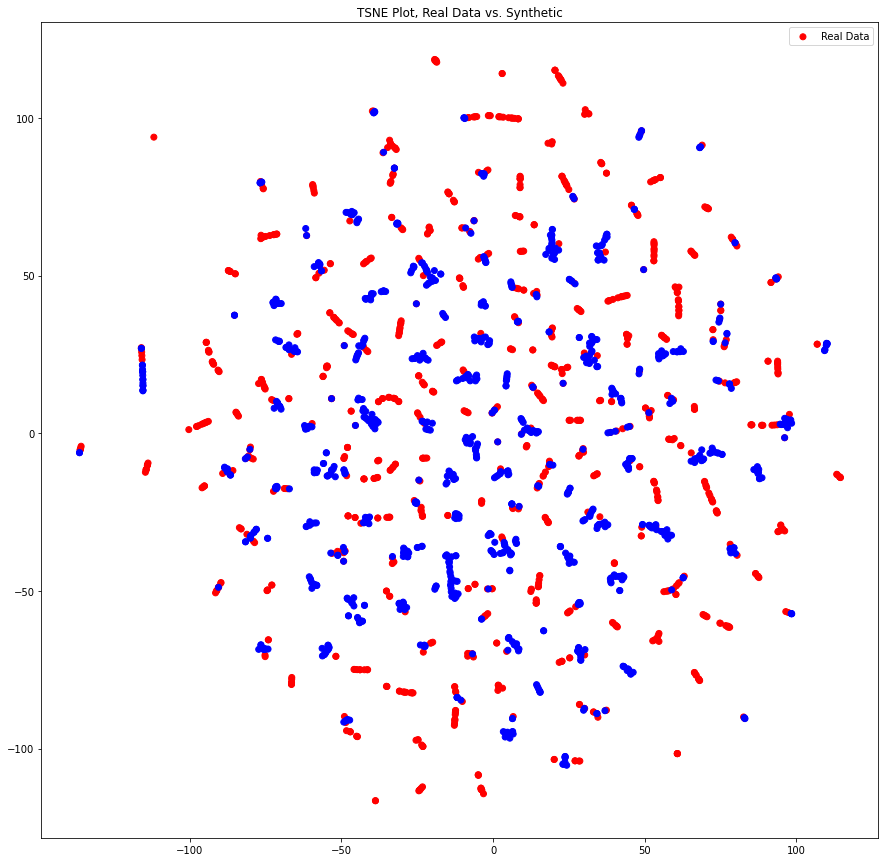

In [152]:
comb = np.vstack((x_train[:1000], x_train_synth[:1000]))
embedding_1 = TSNE(n_components=2, perplexity=5.0, early_exaggeration=1.0).fit_transform(comb)
x,y = embedding_1.T
l = int(len(x) / 2)
inds = []

plt.rcParams["figure.figsize"] = (15,15)
plt.scatter(x,y,c=['purple' if i in inds else 'red' for i in range(l)]+['purple' if j in inds else 'blue' for j in range(l)])
plt.gca().legend(('Real Data','Real'))
plt.title('TSNE Plot, Real Data vs. Synthetic')
plt.show()

Initializing iteration with columns [0 1]
Estimate duration till completion: 0.0 seconds (lower bound)


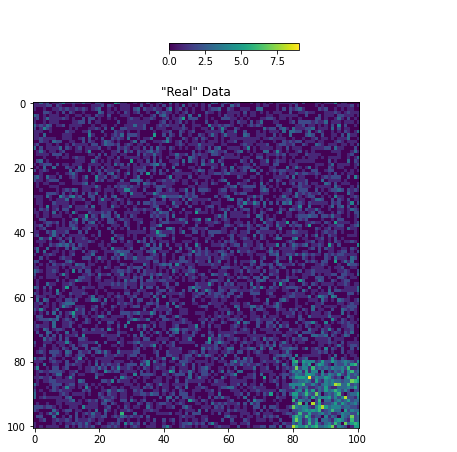

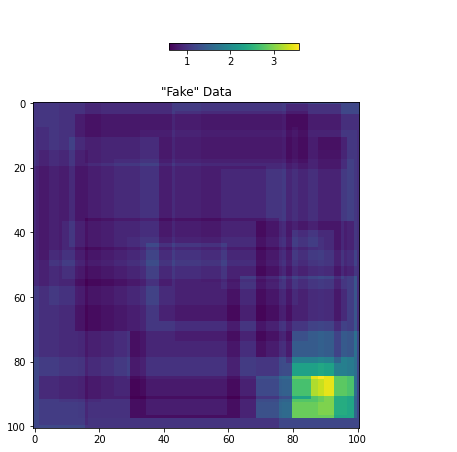

In [192]:
df = pd.read_csv('fake_data_2d.csv')
nf = df.to_numpy()

synth = MWEMSynthesizer(400, 10.0, 30, 20,[[0,1]])
synth.fit(nf)

fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111)
ax.set_title('"Real" Data')
plt.imshow(synth.synthetic_histograms[0][1])
ax.set_aspect('equal')
cax = fig.add_axes([0.1, 1.0, 1., 0.1])
cax.get_xaxis().set_visible(False)
cax.get_yaxis().set_visible(False)
cax.set_frame_on(False)
plt.colorbar(orientation='horizontal')
plt.show()

fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111)
ax.set_aspect('equal')
ax.set_title('"Fake" Data')
plt.imshow(synth.synthetic_histograms[0][0])
cax = fig.add_axes([0.1, 1.0, 1., 0.1])
cax.get_xaxis().set_visible(False)
cax.get_yaxis().set_visible(False)
cax.set_frame_on(False)
plt.colorbar(orientation='horizontal')
plt.show()

/home/lurosenb/anaconda3/envs/oss_dp_2/lib/python3.8/site-packages/opendp/whitenoise/synthesizers/mwem.py:230: Warning: Bin count 101 in column: 0 exceeds max_bin_count, defaulting to: 50. Is this a continuous variable?
  warnings.warn('Bin count ' + str(bin_count) + ' in column: ' + str(split[i]) + \
/home/lurosenb/anaconda3/envs/oss_dp_2/lib/python3.8/site-packages/opendp/whitenoise/synthesizers/mwem.py:230: Warning: Bin count 101 in column: 1 exceeds max_bin_count, defaulting to: 50. Is this a continuous variable?
  warnings.warn('Bin count ' + str(bin_count) + ' in column: ' + str(split[i]) + \


Initializing iteration with columns [0 1]
Estimate duration till completion: 0.0 seconds (lower bound)


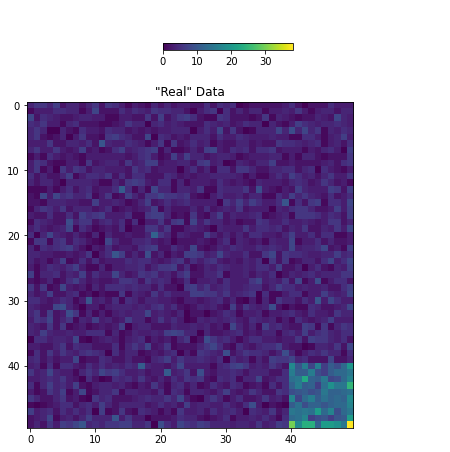

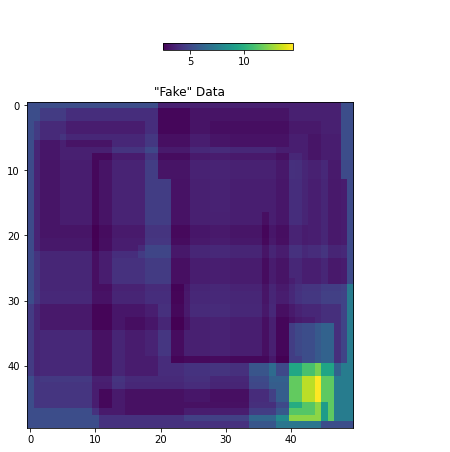

In [193]:
df = pd.read_csv('fake_data_2d.csv')
nf = df.to_numpy()

synth = MWEMSynthesizer(400, 10.0, 30, 20,[[0,1]],max_bin_count=50)
synth.fit(nf)

fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111)
ax.set_title('"Real" Data')
plt.imshow(synth.synthetic_histograms[0][1])
ax.set_aspect('equal')
cax = fig.add_axes([0.1, 1.0, 1., 0.1])
cax.get_xaxis().set_visible(False)
cax.get_yaxis().set_visible(False)
cax.set_frame_on(False)
plt.colorbar(orientation='horizontal')
plt.show()

fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111)
ax.set_aspect('equal')
ax.set_title('"Fake" Data')
plt.imshow(synth.synthetic_histograms[0][0])
cax = fig.add_axes([0.1, 1.0, 1., 0.1])
cax.get_xaxis().set_visible(False)
cax.get_yaxis().set_visible(False)
cax.set_frame_on(False)
plt.colorbar(orientation='horizontal')
plt.show()